## Import

In [1]:
import json
import base64
import cv2
import numpy as np
import mmcv
import pandas as pd
import matplotlib.pyplot as plt
import shutil as shu
import os
%matplotlib inline

from tqdm import tqdm
from PIL import Image
from io import BytesIO
from glob import glob
from skimage import io
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split


## 시각화

In [4]:
def detected_img(json_path):
    
    with open(json_path, "r") as f:
        data = json.load(f)
        
    img = Image.open(BytesIO(base64.b64decode(data['imageData'])))
    img = np.array(img, np.uint8)
    draw_img = img.copy()
    
    for i in range(len(data['shapes'])):
        label = data['shapes'][i]['label']
        
        poly = np.ravel(data['shapes'][i]['points'])
        
        poly_x = [poly[i] for i in range(len(poly)) if i % 2 == 0]
        poly_y = [poly[i] for i in range(len(poly)) if i % 2 == 1]
        
        xmin, ymin, xmax, ymax = int(min(poly_x)), int(min(poly_y)), int(max(poly_x)), int(max(poly_y))
        cv2.rectangle(draw_img, (xmin, ymin), (xmax, ymax), (0, 255, 0), thickness = 2)
        cv2.putText(draw_img, label, (xmin, ymin - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.67,(255, 0, 0), 1)
        
    return draw_img

In [11]:
train_paths = glob("/media/bgw2001/One Touch/project/HardCover_ObjectDetection/data/train/*.json")


for i in range(len(train_paths)):
    p = train_paths[i]
    p = p.replace("\\","/")
    train_paths[i] = p

train_paths = sorted(train_paths)
train_paths[:10]

['./data/train/train_100000.json',
 './data/train/train_100001.json',
 './data/train/train_100002.json',
 './data/train/train_100003.json',
 './data/train/train_100004.json',
 './data/train/train_100005.json',
 './data/train/train_100006.json',
 './data/train/train_100007.json',
 './data/train/train_100008.json',
 './data/train/train_100009.json']

(576, 576, 3)


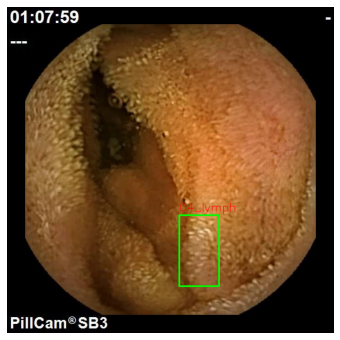

In [13]:
draw_img = detected_img(train_paths[0])
print(draw_img.shape)
plt.figure(figsize=(6,6))
plt.imshow(draw_img)
plt.axis("off")
plt.show()

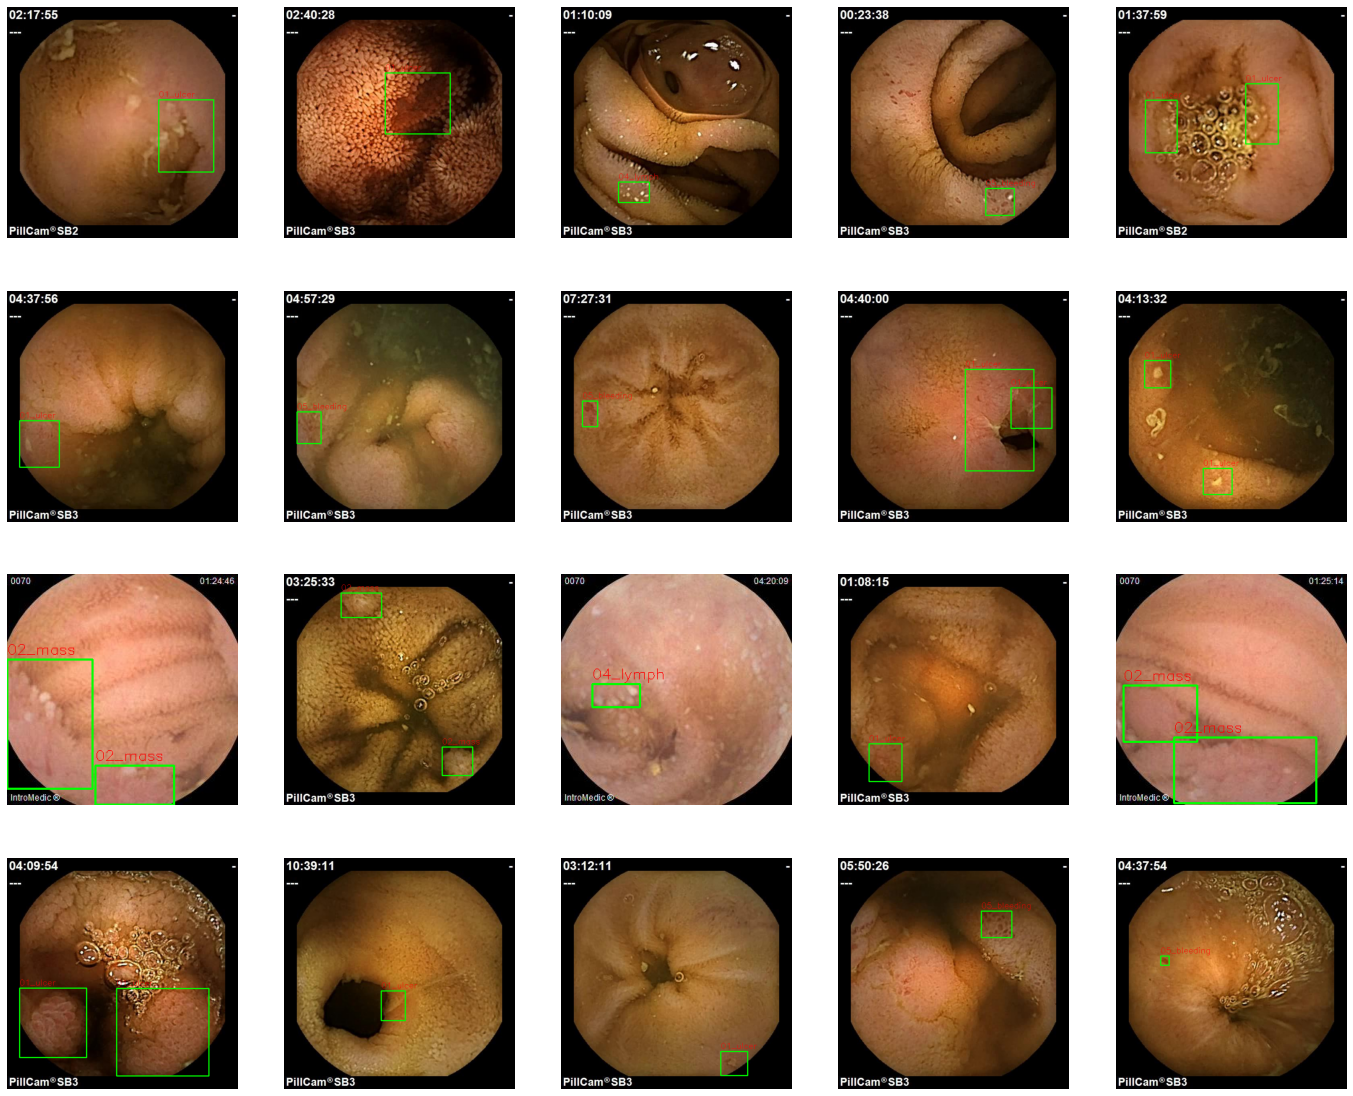

In [14]:
plt.figure(figsize=(24,20))

for i in range(20):
    index = np.random.randint(0, len(train_paths))
    tmp_path = train_paths[index]
    
    draw_img = detected_img(tmp_path)
    
    plt.subplot(4, 5, i+1)
    plt.imshow(draw_img)
    plt.axis("off")

In [15]:
with open(train_paths[100], "r") as f:
  data = json.load(f)


print("file name:",data['file_name'])
index = 1
for shape in data['shapes']:
  print("label %s: " % index, shape['label'])
  index += 1

file name: train_100100.json
label 1:  04_lymph
label 2:  04_lymph


In [2]:
file_names = []
labels = []

train_paths = glob("/media/bgw2001/One Touch/project/HardCover_ObjectDetection/data/train/*.json")

for i in tqdm(range(len(train_paths))):
    with open(train_paths[i], 'r') as f:
        data = json.load(f)
    
    filename = data['file_name']
    
    for shape in data['shapes']:
        label = shape['label']
        labels.append(label)
        file_names.append(filename)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62622/62622 [02:00<00:00, 520.75it/s]


In [3]:
print(len(file_names) == len(labels))

train_df= pd.DataFrame({'file_name':file_names,
                        'label': labels})

print("train json 파일 수:",len(train_paths))
print("Train DataFrame Shape:",train_df.shape)
train_df.head()

True
train json 파일 수: 62622
Train DataFrame Shape: (80218, 2)


,file_name,label
0,train_100000.json,04_lymph
1,train_100001.json,01_ulcer
2,train_100002.json,01_ulcer
3,train_100003.json,01_ulcer
4,train_100004.json,02_mass


In [4]:
cnt_df = train_df['label'].value_counts()
cnt_df = cnt_df.reset_index()

cnt_df['sort_value'] = [0,3,2,1]
cnt_df = cnt_df.sort_values(by = 'sort_value')
cnt_df = cnt_df.reset_index(drop = True)

cnt_df

,index,label,sort_value
0,01_ulcer,38958,0
1,02_mass,9760,1
2,04_lymph,12002,2
3,05_bleeding,19498,3


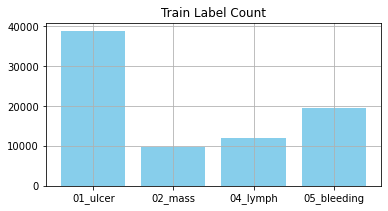

In [5]:
plt.figure(figsize = (6,3))
plt.bar(cnt_df['index'], cnt_df['label'], color = 'skyblue')
plt.grid()
plt.title('Train Label Count')
plt.show()

In [6]:
print(int(len(train_paths) *  0.6))
print(int(len(train_paths) *  0.4 * 0.5))
print(int(len(train_paths) *  0.4 * 0.5))

37573
12524
12524


In [7]:
x_train, x_test, y_train, y_test = train_test_split(train_paths, train_paths, test_size=0.4, random_state= 2021)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state= 2021)

In [8]:
print(len(x_train))
print(len(x_test))
print(len(x_val))

37573
12525
12524


In [9]:
file_names = []
labels = []

for i in tqdm(range(len(x_train))):
    with open(x_train[i], 'r') as f:
        data = json.load(f)
    
    filename = data['file_name']
    
    for shape in data['shapes']:
        label = shape['label']
        labels.append(label)
        file_names.append(filename)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37573/37573 [00:02<00:00, 16582.09it/s]


In [10]:
print(len(file_names) == len(labels))

train_df= pd.DataFrame({'file_name':file_names,
                        'label': labels})

print("train json 파일 수:",len(x_train))
print("Train DataFrame Shape:",train_df.shape)
train_df.head()

True
train json 파일 수: 37573
Train DataFrame Shape: (48205, 2)


,file_name,label
0,train_141915.json,04_lymph
1,train_130379.json,02_mass
2,train_145762.json,05_bleeding
3,train_147219.json,05_bleeding
4,train_104633.json,04_lymph


In [11]:
cnt_df = train_df['label'].value_counts()
cnt_df = cnt_df.reset_index()

cnt_df['sort_value'] = [0,3,2,1]
cnt_df = cnt_df.sort_values(by = 'sort_value')
cnt_df = cnt_df.reset_index(drop = True)

cnt_df

,index,label,sort_value
0,01_ulcer,23439,0
1,02_mass,5795,1
2,04_lymph,7156,2
3,05_bleeding,11815,3


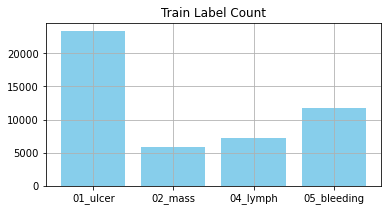

In [12]:
plt.figure(figsize = (6,3))
plt.bar(cnt_df['index'], cnt_df['label'], color = 'skyblue')
plt.grid()
plt.title('Train Label Count')
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12524/12524 [00:00<00:00, 16361.58it/s]


True
train json 파일 수: 12524
Train DataFrame Shape: (16014, 2)


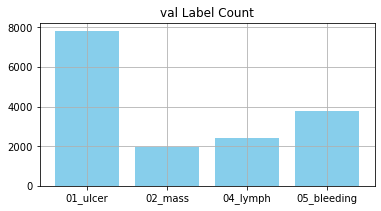

In [13]:
file_names = []
labels = []

for i in tqdm(range(len(x_val))):
    with open(x_val[i], 'r') as f:
        data = json.load(f)
    
    filename = data['file_name']
    
    for shape in data['shapes']:
        label = shape['label']
        labels.append(label)
        file_names.append(filename)
        
print(len(file_names) == len(labels))

val_df= pd.DataFrame({'file_name':file_names,
                        'label': labels})

print("valid json 파일 수:",len(x_val))
print("valid DataFrame Shape:",val_df.shape)
train_df.head()

cnt_df = val_df['label'].value_counts()
cnt_df = cnt_df.reset_index()

cnt_df['sort_value'] = [0,3,2,1]
cnt_df = cnt_df.sort_values(by = 'sort_value')
cnt_df = cnt_df.reset_index(drop = True)

plt.figure(figsize = (6,3))
plt.bar(cnt_df['index'], cnt_df['label'], color = 'skyblue')
plt.grid()
plt.title('val Label Count')
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12525/12525 [00:00<00:00, 16340.78it/s]


True
train json 파일 수: 12525
Train DataFrame Shape: (15999, 2)


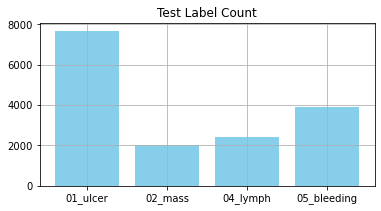

In [14]:
file_names = []
labels = []

for i in tqdm(range(len(x_test))):
    with open(x_test[i], 'r') as f:
        data = json.load(f)
    
    filename = data['file_name']
    
    for shape in data['shapes']:
        label = shape['label']
        labels.append(label)
        file_names.append(filename)
        
print(len(file_names) == len(labels))

test_df= pd.DataFrame({'file_name':file_names,
                        'label': labels})

print("test json 파일 수:",len(x_test))
print("test DataFrame Shape:",test_df.shape)

cnt_df = test_df['label'].value_counts()
cnt_df = cnt_df.reset_index()

cnt_df['sort_value'] = [0,3,2,1]
cnt_df = cnt_df.sort_values(by = 'sort_value')
cnt_df = cnt_df.reset_index(drop = True)

plt.figure(figsize = (6,3))
plt.bar(cnt_df['index'], cnt_df['label'], color = 'skyblue')
plt.grid()
plt.title('Test Label Count')
plt.show()

In [19]:
## train
file_name = []

for i in range(len(x_train)):
    index = x_train[i].rfind("/")
    file_name.append(x_train[i][index+1:])
    
train_df = pd.DataFrame({"path":x_train,
                        "file_name":file_name})
print("train shape:",train_df.shape)

## valid
file_name = []

for i in range(len(x_val)):
    index = x_val[i].rfind("/")
    file_name.append(x_val[i][index+1:])
    
val_df = pd.DataFrame({"path":x_val,
                        "file_name":file_name})

print("valid shape:", val_df.shape)

## test
file_name = []

for i in range(len(x_test)):
    index = x_test[i].rfind("/")
    file_name.append(x_test[i][index+1:])
    
test_df = pd.DataFrame({"path":x_test,
                        "file_name":file_name})

print("test shape:", test_df.shape)

train shape: (37573, 2)
valid shape: (12524, 2)
test shape: (12525, 2)


In [20]:
def data_move(df, mode = 'train'):
    root_dir = "/media/bgw2001/One Touch/project/HardCover_ObjectDetection/data/train/"
    image_move_dir = "/media/bgw2001/One Touch/project/HardCover_ObjectDetection/data/images/%s/" % mode
    json_move_dir = "/media/bgw2001/One Touch/project/HardCover_ObjectDetection/data/json/%s/" % mode
    
    paths = root_dir + df['file_name']
    paths = paths.tolist()
    
    for i in tqdm(range(len(paths))):
        path = paths[i]
        
        with open(path, "r") as f:
            data = json.load(f)
        
        img = Image.open(BytesIO(base64.b64decode(data['imageData'])))
        img = np.array(img, np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        imagefile_name = data['file_name'].replace(".json", ".png")
        jsonfile_name = data['file_name']
        
        cv2.imwrite(image_move_dir + imagefile_name, img)
        shu.copyfile(root_dir + jsonfile_name, json_move_dir + jsonfile_name)

In [21]:
data_move(train_df, mode = 'train')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37573/37573 [16:46<00:00, 37.33it/s]


In [22]:
data_move(val_df, mode = 'valid')
data_move(test_df, mode = 'test')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12525/12525 [03:28<00:00, 59.99it/s]


### CoCoFormat Convert

In [23]:

def cocoformat_convert(paths, output_path):
    
    images = []
    annotations = []
    object_id = 0
    
    classes = pd.read_csv("/media/bgw2001/One Touch/project/HardCover_ObjectDetection/data/class_id_info.csv")
    
    label_to_seq = dict()
    
    for i in range(4):
        label_to_seq[classes.iloc[i,:]['class']] = i
        
    
    for idx, i in tqdm(enumerate(range(len(paths)))):
        path = paths[i]

        with open(path, "r") as f:
            data = json.load(f)
    
        file_name = data['file_name'].replace(".json", ".png")
        height = data['imageHeight']
        width = data['imageWidth']
        
        image = dict(
            id = idx,
            file_name = file_name,
            height = height,
            width = width
        )
        images.append(image)
        
        shapes = data['shapes']
        
        #boxes = []
        #polys = []
        
        for shape in shapes:
            label = shape['label']
            label = label_to_seq[label]
            
            poly = np.ravel(shape['points'])
            
            poly_x = [poly[i] for i in range(len(poly)) if i % 2 == 0]
            poly_y = [poly[i] for i in range(len(poly)) if i % 2 == 1]
            
            xmin, ymin, xmax, ymax = int(min(poly_x)), int(min(poly_y)), int(max(poly_x)), int(max(poly_y))
            
            w = xmax - xmin
            h = ymax - ymin
            
            area = w * h
            
            bbox = [xmin, ymin, w, h]
    
            annotation = dict(
                id = object_id,
                image_id = idx,
                category_id = label,
                bbox = bbox,
                segmentation = [poly],
                area = area,
                iscrowd = 0
            )
            
            annotations.append(annotation)
            object_id += 1
        
    cocoformat = dict(
        images = images,
        annotations = annotations,
        categories = [{"id": 0, "name":"01_ulcer"},
                     {"id": 1, "name":"02_mass"},
                     {"id": 2, "name":"04_lymph"},
                     {"id": 3, "name":"05_bleeding"}]
    )
    
    mmcv.dump(cocoformat, output_path)

In [24]:
classes = pd.read_csv("/media/bgw2001/One Touch/project/HardCover_ObjectDetection/data/class_id_info.csv")
label_to_seq = dict()

for i in range(4):
    label_to_seq[classes.iloc[i,:]['class']] = i
print(label_to_seq)

{'01_ulcer': 0, '02_mass': 1, '04_lymph': 2, '05_bleeding': 3}


In [25]:
train_jsonpath = glob("/media/bgw2001/One Touch/project/HardCover_ObjectDetection/data/json/train/*.json")
cocoformat_convert(train_jsonpath, output_path="/media/bgw2001/One Touch/project/HardCover_ObjectDetection/data/images/train.json")

test_jsonpath = glob("/media/bgw2001/One Touch/project/HardCover_ObjectDetection/data/json/test/*.json")
cocoformat_convert(test_jsonpath, output_path="/media/bgw2001/One Touch/project/HardCover_ObjectDetection/data/images/test.json")

valid_jsonpath = glob("/media/bgw2001/One Touch/project/HardCover_ObjectDetection/data/json/valid/*.json")
cocoformat_convert(valid_jsonpath, output_path="/media/bgw2001/One Touch/project/HardCover_ObjectDetection/data/images/valid.json")

37573it [00:13, 2709.37it/s] 
12525it [00:02, 4211.50it/s]
12524it [00:04, 2762.87it/s]


### Pycocotools
- pycocotools를 사용해서 json 파일이 잘 만들어 졌는지 확인 및 시각화

In [26]:
from pycocotools.coco import COCO

# MS COCO Foramt으로 Json이 잘 컨버트가 됐다면, CoCo 데이터 셋을 만들 수 있다.
annFile = "./data/images/train.json"
print('ann File:',annFile)
coco = COCO(annFile)

ann File: ./data/images/train.json
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [27]:
catIds = coco.getCatIds(catNms=['05_bleeding','01_ulcer'])
imgIds = coco.getImgIds(catIds=catIds)
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
img

{'id': 3073, 'file_name': 'train_161701.png', 'height': 576, 'width': 576}

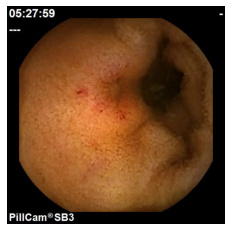

In [28]:
I = io.imread("/media/bgw2001/One Touch/project/HardCover_ObjectDetection/data/images/train/" + img['file_name'])
plt.axis('off')
plt.imshow(I, cmap = 'gray')
plt.show()

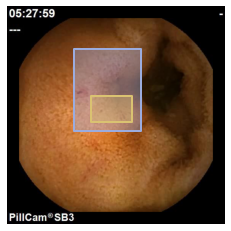

In [29]:
plt.imshow(I, cmap = 'gray'); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)